# KMeans Clustering & Regression - Baseball Analytics
### Predict MLB Team Wins per year (Season)
* Perform EDA on Baseball Teams data
* Utilize KMeans for Clustering
* Compare Linear and Ridge Regression Results

In [1]:
import pandas as pd
import sqlite3

## Load and Explore Data
#### Original data source was from sqlite - This exercise uses the Teams.csv 
* can be retrieved from http://www.seanlahman.com/baseball-archive/statistics/ 

In [6]:
teams_df = pd.read_csv('../../Downloads/baseballdatabank-master/core/Teams.csv')

In [7]:
print(teams_df.head())

   yearID lgID teamID franchID divID  Rank   G  Ghome   W   L     ...       \
0    1871  NaN    BS1      BNA   NaN     3  31    NaN  20  10     ...        
1    1871  NaN    CH1      CNA   NaN     2  28    NaN  19   9     ...        
2    1871  NaN    CL1      CFC   NaN     8  29    NaN  10  19     ...        
3    1871  NaN    FW1      KEK   NaN     7  19    NaN   7  12     ...        
4    1871  NaN    NY2      NNA   NaN     5  33    NaN  16  17     ...        

   DP     FP                     name                          park  \
0  24  0.834     Boston Red Stockings           South End Grounds I   
1  16  0.829  Chicago White Stockings       Union Base-Ball Grounds   
2  15  0.818   Cleveland Forest Citys  National Association Grounds   
3   8  0.803     Fort Wayne Kekiongas                Hamilton Field   
4  14  0.840         New York Mutuals      Union Grounds (Brooklyn)   

   attendance  BPF  PPF  teamIDBR  teamIDlahman45  teamIDretro  
0         NaN  103   98       BOS      

In [8]:
print(len(teams_df))

2865


### Address Unnecessary Variables & Null Values

In [10]:
teams_df.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome',
       'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro'],
      dtype='object')

#### Many Variables will not be useful in Predicting Wins
* drop them

In [14]:
drop_cols = ['lgID', 'franchID', 'divID', 'Rank', 'Ghome', 'L', 'DivWin', 'LgWin', 'WSWin',
             'SF', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro',
             'WCWin']

df = teams_df.drop(drop_cols, axis=1)

print(df.head())

   yearID teamID   G   W    R    AB    H  2B  3B  HR  \
0    1871    BS1  31  20  401  1372  426  70  37   3   
1    1871    CH1  28  19  302  1196  323  52  21  10   
2    1871    CL1  29  10  249  1186  328  35  40   7   
3    1871    FW1  19   7  137   746  178  19   8   2   
4    1871    NY2  33  16  302  1404  403  43  21   1   

               ...               IPouts   HA  HRA  BBA  SOA    E  DP     FP  \
0              ...                  828  367    2   42   23  243  24  0.834   
1              ...                  753  308    6   28   22  229  16  0.829   
2              ...                  762  346   13   53   34  234  15  0.818   
3              ...                  507  261    5   21   17  163   8  0.803   
4              ...                  879  373    7   42   22  235  14  0.840   

                      name                          park  
0     Boston Red Stockings           South End Grounds I  
1  Chicago White Stockings       Union Base-Ball Grounds  
2   Clevela

#### List how many null values are present - in remaining variables
* These values can be dropped or modified

In [15]:
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 120, 126, 832, 1326, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 34]


In [16]:
df.columns

Index(['yearID', 'teamID', 'G', 'W', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB',
       'SO', 'SB', 'CS', 'HBP', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts',
       'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'name', 'park'],
      dtype='object')

* Caught Stealing 'CS' & Hit By Pitch 'HBP' - have many nulls - probably not relevant to the Wins target
    * Drop these variables
* Fill the nulls for some of the other variables - with Median values of those variables

In [17]:
df = df.drop(['CS','HBP'], axis=1)

df['SO'] = df['SO'].fillna(df['SO'].median())
df['DP'] = df['DP'].fillna(df['DP'].median())

In [18]:
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 34]


## Visualize the Wins Distribution
* %matplotlib alone (NO 'inline') - opens plot in a new window

#### Histogram

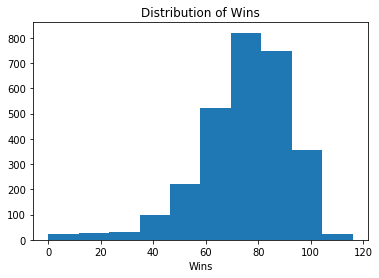

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(df['W'])
plt.xlabel('Wins')
plt.title('Distribution of Wins')

plt.show()

In [21]:
print(df['W'].mean())

74.87853403141361


#### Assign bins to the target (Wins) column - Then, create a New Column, win_bins
* create function, assign_win_bins
* use apply ( )

In [23]:
def assign_win_bins(W):
    if W < 50:
        return 1
    if W >= 50 and W <=69:
        return 2
    if W >= 70 and W <=89:
        return 3
    if W >= 90 and W <= 109:
        return 4
    if W >= 110:
        return 5

df['win_bins'] = df['W'].apply(assign_win_bins)

#### Scatter Plot - Year vs. Wins

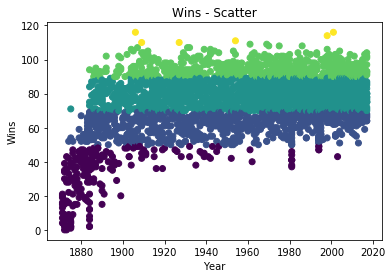

In [24]:
plt.scatter(df['yearID'], df['W'], c=df['win_bins'])
plt.title('Wins - Scatter')
plt.xlabel('Year')
plt.ylabel('Wins')

plt.show()

* there appear to be many fewer Wins - prior to 1890

#### Focus on the more contemporary game of Baseball - by Dropping this data, and other unnecessary data
* drop data before 1890
* drop data with seasons under 150 games

In [25]:
df = df[df['yearID'] > 1890]

In [26]:
df = df[df['G'] >= 150]

## Address the different Scoring Eras associated with Baseball
* the low-scoring Dead-Ball era (around 1900) - high-scoring Steroid era (late 20th century)
* create dictionaries for Runs/year and Games/year
    * iterrate through df with iterrate( )
* create Graph - how much scoring each year

In [27]:
runs_per_year = {}
games_per_year = {}

for i, row in df.iterrows():
    year = row['yearID']
    runs = row['R']
    games = row['G']
    
    if year in runs_per_year:
        runs_per_year[year] = runs_per_year[year] + runs
        games_per_year[year] = games_per_year[year] + games
    else:
        runs_per_year[year] = runs
        games_per_year[year] = games
    
print(runs_per_year)
print(games_per_year)

{1892: 8753, 1898: 8491, 1899: 8780, 1904: 9307, 1905: 9640, 1906: 8322, 1907: 8186, 1908: 8423, 1909: 8805, 1910: 9580, 1911: 11164, 1912: 11154, 1913: 9964, 1914: 14532, 1915: 14213, 1916: 8889, 1917: 8948, 1920: 10762, 1921: 11935, 1922: 12059, 1923: 11874, 1924: 11722, 1925: 12596, 1926: 11443, 1927: 11745, 1928: 11645, 1929: 12747, 1930: 13695, 1931: 11892, 1932: 12116, 1933: 10288, 1934: 11325, 1935: 10498, 1936: 12846, 1937: 12070, 1938: 11260, 1939: 11876, 1940: 11568, 1941: 11168, 1942: 9457, 1943: 9694, 1944: 10353, 1945: 9729, 1946: 9953, 1947: 10827, 1948: 11328, 1949: 11426, 1950: 12013, 1951: 11268, 1952: 10349, 1953: 11426, 1954: 10827, 1955: 11069, 1956: 11031, 1957: 10636, 1958: 10578, 1959: 10853, 1960: 10664, 1961: 12942, 1962: 14461, 1963: 12780, 1964: 13124, 1965: 12946, 1966: 12900, 1967: 12210, 1968: 11109, 1969: 15850, 1970: 16880, 1971: 15073, 1972: 13706, 1973: 16376, 1974: 16046, 1975: 16295, 1976: 15492, 1977: 18803, 1978: 17251, 1979: 18713, 1980: 18053, 19

* create dictionary MLB Runs/game
    * This Time, iterrate through games_per_year - using items( )

In [28]:
mlb_runs_per_game = {}

for k, v in games_per_year.items():
    year = k
    games = v
    runs = runs_per_year[year]
    mlb_runs_per_game[year] = runs / games
    
print(mlb_runs_per_game)

{1892: 5.1792899408284025, 1898: 5.021289178001183, 1899: 5.182998819362456, 1904: 3.7257806244995995, 1905: 3.896523848019402, 1906: 3.6072821846553964, 1907: 3.5330168321104876, 1908: 3.385450160771704, 1909: 3.5475423045930703, 1910: 3.8350680544435547, 1911: 4.512530315278901, 1912: 4.526785714285714, 1913: 4.037277147487845, 1914: 3.8648936170212767, 1915: 3.8125, 1916: 3.5641539695268647, 1917: 3.587810745789896, 1920: 4.360615883306321, 1921: 4.855573637103336, 1922: 4.870355411954765, 1923: 4.815085158150851, 1924: 4.761169780666125, 1925: 5.128664495114006, 1926: 4.636547811993517, 1927: 4.75121359223301, 1928: 4.729894394800975, 1929: 5.185923515052888, 1930: 5.5490275526742305, 1931: 4.810679611650485, 1932: 4.913219789132198, 1933: 4.467216673903604, 1934: 4.9303439268611235, 1935: 4.86468952734013, 1936: 5.188206785137318, 1937: 4.870863599677159, 1938: 4.902046147148455, 1939: 4.823720552396425, 1940: 4.679611650485437, 1941: 4.488745980707395, 1942: 4.111739130434783, 19

#### Plot mlb_runs_per_game

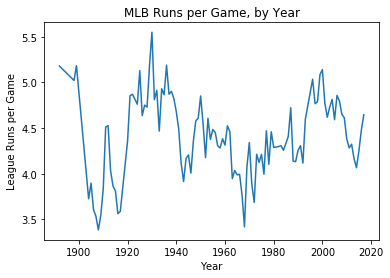

In [29]:
lists = sorted(mlb_runs_per_game.items())

x, y = zip(*lists)

plt.plot(x, y)
plt.title('MLB Runs per Game, by Year')
plt.xlabel('Year')
plt.ylabel('League Runs per Game')

plt.show()

#### With this insight, Variable can be created to represent Scoring Eras
* Similar process to creating win_bins (earlier) - create year_label
    * This Time, create Dummy Columns (new columns) for each Era
        * using get_dummies( )
    * concatenate the dummy DataFrame to df

In [30]:
def assign_label(year):
    if year < 1920:
        return 1
    if year >= 1920 and year <= 1941:
        return 2
    if year >= 1942 and year <= 1945:
        return 3
    if year >= 1946 and year <= 1962:
        return 4
    if year >= 1963 and year <= 1976:
        return 5
    if year >= 1977 and year <= 1992:
        return 6
    if year >= 1993 and year <= 2009:
        return 7
    if year >= 2010:
        return 8
    
df['year_label'] = df['yearID'].apply(assign_label)

dummy_df = pd.get_dummies(df['year_label'], prefix='era')

df = pd.concat([df, dummy_df], axis=1)

print(df.head())

     yearID teamID    G    W    R    AB     H   2B   3B  HR  ...    win_bins  \
279    1892    BLN  152   46  779  5296  1343  160  111  30  ...           1   
280    1892    BRO  158   95  935  5485  1439  183  105  30  ...           4   
281    1892    BSN  152  102  862  5301  1325  203   51  34  ...           4   
283    1892    CIN  155   82  766  5349  1291  155   75  44  ...           3   
284    1892    CL4  152   93  855  5412  1376  196   96  26  ...           4   

     year_label  era_1  era_2  era_3  era_4  era_5  era_6  era_7  era_8  
279           1      1      0      0      0      0      0      0      0  
280           1      1      0      0      0      0      0      0      0  
281           1      1      0      0      0      0      0      0      0  
283           1      1      0      0      0      0      0      0      0  
284           1      1      0      0      0      0      0      0      0  

[5 rows x 39 columns]


#### Add mlb_runs_per_game to df

In [31]:
def assign_mlb_rpg(year):
    return mlb_runs_per_game[year]

df['mlb_rpg'] = df['yearID'].apply(assign_mlb_rpg)

#### Convert years to Decades - Then drop unnecessary columns (yearID, year_label, decade_label)
* create function, assign_decade(year)
* again, use dummy variables

In [32]:
def assign_decade(year):
    if year < 1920:
        return 1890
    elif year >= 1920 and year <= 1929:
        return 1920
    elif year >= 1930 and year <= 1939:
        return 1930
    elif year >= 1940 and year <= 1949:
        return 1940
    elif year >= 1950 and year <= 1959:
        return 1950
    elif year >= 1960 and year <= 1969:
        return 1960
    elif year >= 1970 and year <= 1979:
        return 1970
    elif year >= 1980 and year <= 1989:
        return 1980
    elif year >= 1990 and year <= 1999:
        return 1990
    elif year >= 2000 and year <= 2009:
        return 2000
    elif year >= 2010:
        return 2010
    
df['decade_label'] = df['yearID'].apply(assign_decade)

decade_df = pd.get_dummies(df['decade_label'], prefix='decade')

df = pd.concat([df, decade_df], axis=1)

df = df.drop(['yearID', 'year_label', 'decade_label'], axis=1)

## Increase Model Accuracy - by ratio columns
* focus on Runs Scored & Runs Allowed - per game
* Pandas makes this easy

In [33]:
df['R_per_game'] = df['R'] / df['G']

df['RA_per_game'] = df['RA'] / df['G']

#### See the relationship between these new columns, and the Target (Wins) column
* plot runs per game vs. wins
* plot runs allowed per game vs. wins

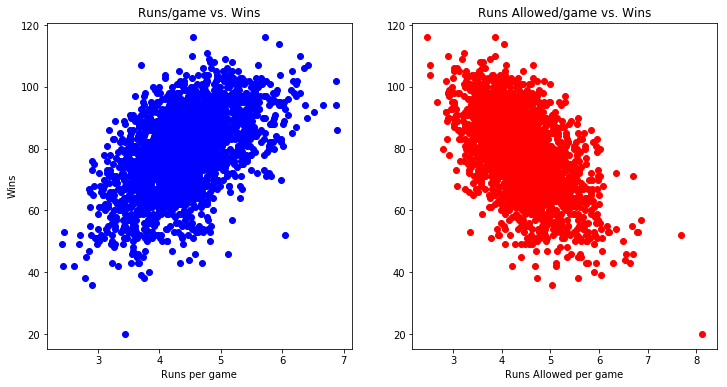

In [34]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(df['R_per_game'], df['W'], c='blue')
ax1.set_title('Runs/game vs. Wins')
ax1.set_ylabel('Wins')
ax1.set_xlabel('Runs per game')

ax2.scatter(df['RA_per_game'], df['W'], c='red')
ax2.set_title('Runs Allowed/game vs. Wins')
ax2.set_xlabel('Runs Allowed per game')

plt.show()

#### View how variables Correlate with Target

In [35]:
df.corr()['W']

G              0.181460
W              1.000000
R              0.549188
AB             0.234551
H              0.381802
2B             0.269314
3B             0.008830
HR             0.307676
BB             0.350046
SO             0.081505
SB             0.121607
RA            -0.529623
ER            -0.374377
ERA           -0.431165
CG            -0.053637
SHO            0.435098
SV             0.376264
IPouts         0.328742
HA            -0.396648
HRA            0.017332
BBA           -0.278307
SOA            0.259465
E             -0.284941
DP             0.021717
FP             0.297669
win_bins       0.913000
era_1         -0.086015
era_2         -0.079177
era_3         -0.031603
era_4         -0.049411
era_5          0.042702
era_6          0.058789
era_7          0.066315
era_8          0.047121
mlb_rpg        0.001340
decade_1890   -0.086015
decade_1920   -0.052700
decade_1930   -0.049971
decade_1940   -0.047900
decade_1950   -0.045208
decade_1960    0.029178
decade_1970    0

# Machine Learning
## K-means Clustering
* data is partitioned by the indicated number of k centroids, and each data point is assigned to a cluster, based on which k centroid is the closest Euclidean distance to the point

#### Create a dataFrame - sans the Target variable

In [38]:
attributes = ['G', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'RA', 'ER', 'ERA',
              'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
              'win_bins', 'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7',
              'era_8', 'mlb_rpg', 'decade_1890', 'decade_1920', 'decade_1930', 'decade_1940',
              'decade_1950', 'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990',
              'decade_2000', 'decade_2010', 'R_per_game', 'RA_per_game']

data_attributes = df[attributes]

print(data_attributes.head())

       G    R    AB     H   2B   3B  HR     BB     SO     SB     ...       \
279  152  779  5296  1343  160  111  30  499.0  480.0  227.0     ...        
280  158  935  5485  1439  183  105  30  629.0  508.0  409.0     ...        
281  152  862  5301  1325  203   51  34  526.0  492.0  338.0     ...        
283  155  766  5349  1291  155   75  44  503.0  476.0  270.0     ...        
284  152  855  5412  1376  196   96  26  552.0  538.0  225.0     ...        

     decade_1940  decade_1950  decade_1960  decade_1970  decade_1980  \
279            0            0            0            0            0   
280            0            0            0            0            0   
281            0            0            0            0            0   
283            0            0            0            0            0   
284            0            0            0            0            0   

     decade_1990  decade_2000  decade_2010  R_per_game  RA_per_game  
279            0            0     

#### Find Ideal Number of k - Use silhouette_score( ) 
* Create a silhouette score dictionary
* A higher score is better - however, the score decreases as clusters are added

In [39]:
from sklearn.cluster import KMeans
from sklearn import metrics

s_score_dict = {}

for i in range(2,11):
    km = KMeans(n_clusters = i, random_state = 1)
    l = km.fit_predict(data_attributes)
    s_s = metrics.silhouette_score(data_attributes, l)
    s_score_dict[i] = [s_s]
    
print(s_score_dict)

{2: [0.399250714145236], 3: [0.253520695001829], 4: [0.25347490413291296], 5: [0.23246667769673615], 6: [0.21371097632233743], 7: [0.19572738603100584], 8: [0.18853939538585693], 9: [0.17621585471084075], 10: [0.17335509276889483]}


#### Initialize the Model - 6 clusters
* find Euclidean distances - using fit_transform( )

In [40]:
kmeans_model = KMeans(n_clusters = 6, random_state = 1)

distances = kmeans_model.fit_transform(data_attributes)

#### Scatter Plot of Clusters

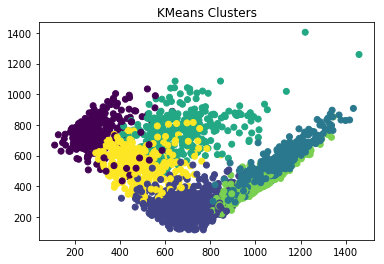

In [41]:
labels = kmeans_model.labels_

plt.scatter(distances[:, 0], distances[:, 1], c=labels)
plt.title('KMeans Clusters')

plt.show()

#### Add Cluster Labels to df - as a New Column
* Also, Add string 'labels' - to attributes List for future use

In [42]:
df['labels'] = labels
attributes.append('labels')

print(df.head())

    teamID    G    W    R    AB     H   2B   3B  HR     BB   ...    \
279    BLN  152   46  779  5296  1343  160  111  30  499.0   ...     
280    BRO  158   95  935  5485  1439  183  105  30  629.0   ...     
281    BSN  152  102  862  5301  1325  203   51  34  526.0   ...     
283    CIN  155   82  766  5349  1291  155   75  44  503.0   ...     
284    CL4  152   93  855  5412  1376  196   96  26  552.0   ...     

     decade_1950  decade_1960  decade_1970  decade_1980  decade_1990  \
279            0            0            0            0            0   
280            0            0            0            0            0   
281            0            0            0            0            0   
283            0            0            0            0            0   
284            0            0            0            0            0   

     decade_2000  decade_2010  R_per_game  RA_per_game  labels  
279            0            0    5.125000     6.710526       3  
280            0

#### Split data into Training and Test sets - 75/25 split

In [44]:
attributes = ['G', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'RA', 'ER', 'ERA',
              'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
              'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7',
              'era_8', 'mlb_rpg', 'decade_1890', 'decade_1920', 'decade_1930', 'decade_1940',
              'decade_1950', 'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990',
              'decade_2000', 'decade_2010', 'R_per_game', 'RA_per_game']

numeric_cols = ['G', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'RA', 'ER', 'ERA',
              'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
              'labels', 'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7',
              'era_8', 'mlb_rpg', 'decade_1890', 'decade_1920', 'decade_1930', 'decade_1940',
              'decade_1950', 'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990',
              'decade_2000', 'decade_2010', 'R_per_game', 'RA_per_game','W']

data = df[numeric_cols]

train = data.sample(frac=0.75, random_state=1)
test = data.loc[~data.index.isin(train.index)]

x_train = train[attributes]
x_test = test[attributes]

y_train = train['W']
y_test = test['W']

### Assign Error Metric - MAE
### Fit Model and Predict - Linear Regression

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lr = LinearRegression(normalize=True)

lr.fit(x_train, y_train)

predictions = lr.predict(x_test)

mae = mean_absolute_error(y_test, predictions)

print(mae)

2.8477394466905523


#### The average wins per year (retrieved earlier) was 74.88
* The linear regression model predictions were off by about 2.85 wins

### Fit another Model and Predict - Ridge Regression

In [47]:
from sklearn.linear_model import RidgeCV

rrm = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), normalize=True)

rrm.fit(x_train, y_train)

predictions_rrm = rrm.predict(x_test)

mae_rrm = mean_absolute_error(y_test, predictions_rrm)

print(mae_rrm)

2.8287207739130715


* the Ridge Regression model predictions were slightly better - only off by about 2.83 wins